In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model
import torch.optim.lr_scheduler as lr_scheduler


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  
split = 0.8
data_train,stoi,itos = util.load_data_with_split(path,split,type='train')
data_test,_,_ = util.load_data_with_split(path,split,type='test')

c = util.config()


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=True)

dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=True)

model = Model(stoi=dataset_train.stoi)
m = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=c.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)


# Training loop
lr decay: https://pytorch.org/docs/stable/optim.html

In [12]:
train_loss = []
test_loss = []
perplexity_train = []
perplexity_test = []

for epoch in range(6000):
    model.train()
    inputs, targets = next(iter(data_loader_train))
    logit,loss = m(inputs,'train', targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        
    model.eval()
    inputs_t, targets_t = next(iter(data_loader_test))

    with torch.inference_mode():
        _,loss_t = m(inputs_t,'train', targets_t)
    scheduler.step(loss_t)


    train_loss.append(loss.detach().numpy())
    test_loss.append(loss_t.detach().numpy())
    perplexity_train.append(torch.exp(loss).detach().numpy())
    perplexity_test.append(torch.exp(loss_t).detach().numpy())



KeyboardInterrupt: 

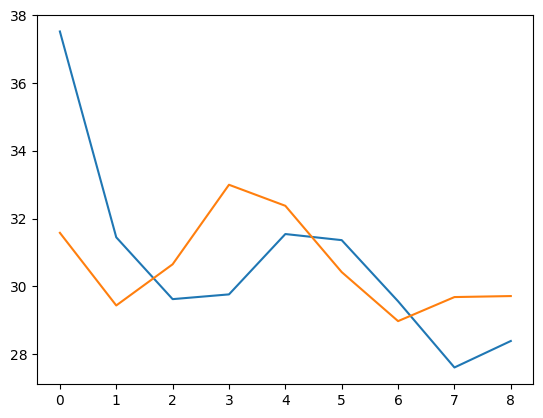

In [14]:
import matplotlib.pyplot as plt
import numpy as np
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,perplexity_train)
plt.plot(epoch_list,perplexity_test)

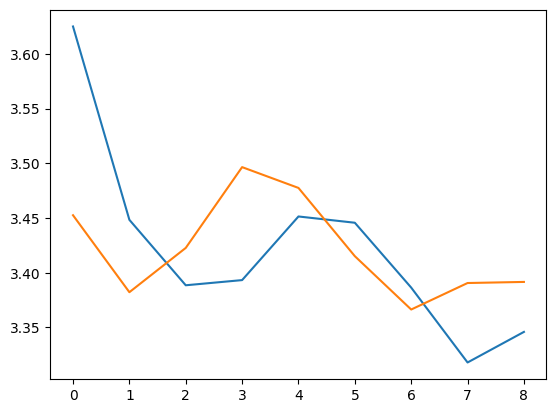

In [15]:
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,train_loss)
plt.plot(epoch_list,test_loss)

# save model

In [9]:
# save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "51_step_no_decay.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=m.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\51_step_no_decay.pth


In [ ]:
MODEL_SAVE_PATH

# generation:

In [10]:
seed = "His cat jumped onto the table, said: We are accounted poor citizens, the patricians good. What authority surfeits on would relieve us: if they would yield us but the superfluity, while it were wholesome, we might guess they relieved us humanely;"

empty = " "*c.sequence_l
seed_idx = util.encode(seed,stoi)
if len(seed)<c.sequence_l: 
    input_idx = util.encode(empty,stoi)
    input_idx[-len(seed):] = seed_idx
else:
    input_idx = seed_idx[:c.sequence_l]

input_idx = torch.tensor(input_idx,dtype=torch.long).to(device)

In [11]:
m.eval()
with torch.no_grad():
    out = m.generate(20,input_idx,'multi')
    print(util.decode(out,itos))

His cat jumped onto the table, said: We are accounted poor citizens, the patricians good. What authority surfeits on would relie,iw.,ub,-t?dfh,baesy


In [ ]:
out
c.sequence_l